# Lab 1:Neural Network 
This notebook has been prepared by Hsiu-Wen (Kelly) Chang from MINES ParisTech for the class of HPC-AI 2022


## Goal
Part 1: Understand how NN works without advanced modules
Part 2: Practice the use of neural network from sratch: architecture, activations, training
Part 3: Practice the use of pytorch convolution neural network


MNIST data setup
----------------

To practice neural network, we are going to targeting the application of predicting the hand-drawn digits (between 0 and 9) in a given black-and-white image

![](http://perso.mines-paristech.fr/fabien.moutarde/ES_MachineLearning/TP_convNets/mnist.png)  
You can use [pathlib](https://docs.python.org/3/library/pathlib.html)
for dealing with paths (part of the Python 3 standard library), and download the dataset using
[requests](http://docs.python-requests.org/en/master/). We will only
import modules when we use them, so you can see exactly what's being
used at each point.

Another way is use torchvision.datasets.MNIST which we will show you later


In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

I recommend running this tutorial as a notebook, not a script. To download the notebook (.ipynb) file,
click the link at the top of the page.

PyTorch provides the elegantly designed modules and classes. 
In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they're
doing. To develop this understanding, we will first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will
incrementally add one feature from ``torch.nn``, ``torch.optim``, ``Dataset``, or
``DataLoader`` at a time, showing exactly what each piece does, and how it
works to make the code either more concise, or more flexible.

**This tutorial assumes you already have PyTorch installed, and are familiar
with the basics of tensor operations.**
If you don't have Pytorch, install it by using this [website](https://pytorch.org/)

This dataset is in numpy array format, and has been stored using pickle,
a python-specific format for serializing data.



In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length
784 (=28x28). Let's take a look at one; we need to reshape it to 2d
first.



(50000, 784)


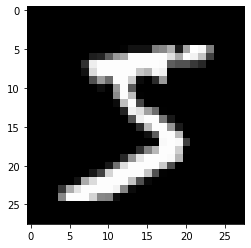

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch uses ``torch.tensor``, rather than numpy arrays, so we need to
convert our data.



In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


Neural network from scratch 
---------------------------------------------

Let's first create a model with only one layer using nothing but PyTorch tensor operations. 
Follow these steps to create the corresponding functions:

(1) Use tensors to store information: x = torch.tensor(x) or any built-in functions of torch 

(2) Initialize weights by [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialisation

(3) use ``requires_grad`` to tell the computer that they require a gradient. This means that Pytorch will record all of the operations done on the tensor and calculate the gradient during back-propagation automatically.

In [6]:
import math
# Create a NN with linear model and (28*28) inputs and 10 outputs
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Pytorch has several built-in activation functions, however, it is necessary to know how to define one by yourself. PyTorch will
even create fast GPU or vectorized CPU code for your function automatically. Let's define log_softmax function and use it as our activation to increase the complexity of our NN

$${\bf \theta} = \log\left(\frac{{\exp}({x_{i})}}{\sum_{j}{\bf \exp}({x_{j})}}\right)$$
$${\bf \theta} = x-\log{\sum_{j}{\bf \exp}({x_{j})}}$$

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In the above, the ``@`` stands for the dot product operation.

Now we design a batch size of 64 to train each time

In [8]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
print(xb.shape)
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

torch.Size([64, 784])
tensor([-2.0798, -2.4968, -2.8252, -2.6060, -2.7734, -2.1135, -1.7448, -1.7852,
        -2.7250, -2.6835], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the ``preds`` tensor contains not only the tensor values, but also a
gradient function. We'll use this later to do backprop.

Let's implement negative log-likelihood to use as the loss function
(again, we can just use standard Python):



In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let's check our loss with our random model, so we can see if we improve
after a backprop pass later.



In [10]:
yb = y_train[0:bs]
print(preds[range(yb.shape[0]),yb])
print(loss_func(preds, yb))

tensor([-2.1135, -2.3124, -2.4757, -2.5412, -2.7466, -2.4954, -2.7826, -2.2192,
        -2.5240, -2.2003, -2.2660, -2.0316, -2.1260, -1.7193, -2.4207, -1.8295,
        -2.5024, -1.8236, -1.9757, -3.2747, -2.8872, -2.3600, -2.7465, -2.5222,
        -2.1696, -2.4252, -2.0631, -1.9950, -2.4158, -2.3993, -2.1243, -2.0216,
        -2.0863, -2.8369, -2.3775, -2.2204, -1.5008, -2.6209, -2.2450, -1.8040,
        -2.3982, -1.7576, -2.2805, -3.0250, -2.1237, -2.7980, -2.2090, -2.1666,
        -2.6526, -2.3862, -2.3988, -2.1466, -2.2198, -2.1561, -2.6985, -2.4020,
        -2.4442, -2.8429, -2.7311, -2.5169, -2.7115, -2.3815, -1.7921, -2.4341],
       grad_fn=<IndexBackward>)
tensor(2.3418, grad_fn=<NegBackward>)


Let's also implement a function to calculate the accuracy of our model.
For each prediction, if the index with the largest value matches the
target value, then the prediction was correct.



In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Let's check the accuracy of our random model, so we can see if our
accuracy improves as our loss improves.



In [12]:
print(accuracy(preds, yb))

tensor(0.1406)


We can now run a training loop.  For each iteration, we will:

- select a mini-batch of data (of size ``bs``)
- use the model to make predictions
- calculate the loss
- ``loss.backward()`` updates the gradients of the model, in this case, ``weights``
  and ``bias``.

We now use these gradients to update the weights and bias.  We do this
within the ``torch.no_grad()`` context manager, because we do not want these
actions to be recorded for our next calculation of the gradient.  You can read
more about how PyTorch's Autograd records operations
`here <https://pytorch.org/docs/stable/notes/autograd.html>`_.

We then set the
gradients to zero, so that we are ready for the next loop.
Otherwise, our gradients would record a running tally of all the operations
that had happened (i.e. ``loss.backward()`` *adds* the gradients to whatever is
already stored, rather than replacing them).

.. tip:: You can use the standard python debugger to step through PyTorch
   code, allowing you to check the various variable values at each step.
   Uncomment ``set_trace()`` below to try it out.




In [13]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1): #floor division
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
        
    print('Epochs {}: loss {}, accuracy {}'.format(epoch, loss_func(model(xb), yb), accuracy(model(xb), yb)))

Epochs 0: loss 0.10872115194797516, accuracy 1.0
Epochs 1: loss 0.08013996481895447, accuracy 1.0


That's it: we've created and trained a minimal neural network (in this case, a
logistic regression, since we have no hidden layers) entirely from scratch!

Let's check the loss and accuracy and compare those to what we got
earlier. We expect that the loss will have decreased and accuracy to
have increased, and they have.



In [14]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0801, grad_fn=<NegBackward>) tensor(1.)


Assignment 1: Using torch.nn.functional
------------------------------
The above work can be easily done by using torch.nn.functional. Please rewrite the above code to be more concise and flexible. Make it shorter, more understandable.

Here is the list of modules that you should try to read:
1. [torch.nn](https://pytorch.org/docs/stable/nn.html)
2. [torch.optim](https://pytorch.org/docs/stable/optim.html)
3. [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)
4. [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

### Step 1 
find activation and loss function from ``torch.nn.functional``

In [15]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [20]:
# Check your loss and accuracy are the same like before
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3617, grad_fn=<NllLossBackward>) tensor(0.)


### Step 2
Use a class to define the architecture

In [21]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        #subclass of tensor that has very specialproperty in Module attributes
        self.bias = nn.Parameter(torch.zeros(10)) 

    def forward(self, xb):
        return xb @ self.weights + self.bias

Instantiate your model and check your loss value



In [22]:
model = Mnist_Logistic()

In [23]:
print(loss_func(model(xb), yb))

tensor(2.4061, grad_fn=<NllLossBackward>)


### Step 3 improve training loop
rewrite the way to update of weights and bias by using nn.Module.parameters and nn.Module.zero_grad()

define a function call fit() to wrap your training loop


In [24]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

Instantiate your function and check loss value



In [25]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0796, grad_fn=<NllLossBackward>)


### Step 4: use nn.Linear
redefine your nn class and replace layer by using [nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers) 

In [26]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

Instantiate our model and calculate the loss in the same way as before:

In [27]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3268, grad_fn=<NllLossBackward>)


We are still able to use our same ``fit`` method as before.



In [28]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward>)


### Step 5 using optim

``torch.optim`` provides various optimization algorithms.
We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

replace our previous manually coded optimization step:
::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()

In [29]:
from torch import optim

We'll define a little function to create our model and optimizer so we
can reuse it in the future.



In [30]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)#stochastic gradient descent

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2676, grad_fn=<NllLossBackward>)
tensor(0.0813, grad_fn=<NllLossBackward>)


### Step 6 using TensorDataset

PyTorch has an abstract Dataset class. A Dataset can be anything that has a __len__ function (called by Python's standard len function) and a __getitem__ function as a way of indexing into it. This [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) walks through a nice example of creating a custom FacialLandmarkDataset class as a subclass of Dataset.

PyTorch's [TensorDataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset) is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [31]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(x_train, y_train)

### Step 6 using DataLoader

Pytorch's ``DataLoader`` is responsible for managing batches. You can
create a ``DataLoader`` from any ``Dataset``. ``DataLoader`` makes it easier
to iterate over batches. Rather than having to use ``train_ds[i*bs : i*bs+bs]``,
the DataLoader gives us each minibatch automatically.



In [32]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=bs)

In [33]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward>)


Thanks to Pytorch's ``nn.Module``, ``nn.Parameter``, ``Dataset``, and ``DataLoader``,
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effecive models in practice.

## Advance functions to make it more effective 

### Step 7 Add validation
In reality, we always need to take care the overfitting issue. We can avoid it by:
(1) add validation
(2) shuffling the training data prevent correlation between batches and overfitting. 

In [34]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [35]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3295)
1 tensor(0.4035)


## Final three lines code

Create fit() and get_data()

(1) Define a function ``loss_batch`` which computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [36]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

(2) ``fit`` runs the necessary operations to train our model and compute the training and validation losses for each epoch.



In [37]:
import numpy as np
# meaning of * is to unpacks a list or tuple into position arguments

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train() #set the mode to training mode. if we use model.train(false), it will become evaluation mode
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

(3) ``get_data`` returns dataloaders for the training and validation sets.



In [38]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:



In [39]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.31253588550686834
1 0.3960293065071106


# Assignment 2: plot loss values and validations values
In order to understand the progress of your training, error curves with test and validation are very common to be shown.
Change your code in order to see the curves

You can use these basic 3 lines of code to train a wide variety of models.
Let's see if we can use them to train a convolutional neural network (CNN)!

Summary 
-----------------

We have seen and practice the following functions

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

